# Table of Contents
 <p><div class="lev1"><a href="#目的"><span class="toc-item-num">1&nbsp;&nbsp;</span>目的</a></div><div class="lev1"><a href="#準備"><span class="toc-item-num">2&nbsp;&nbsp;</span>準備</a></div><div class="lev2"><a href="#import"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>import</a></div><div class="lev2"><a href="#画像データのロード"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>画像データのロード</a></div><div class="lev1"><a href="#モデル定義"><span class="toc-item-num">3&nbsp;&nbsp;</span>モデル定義</a></div><div class="lev1"><a href="#学習"><span class="toc-item-num">4&nbsp;&nbsp;</span>学習</a></div><div class="lev2"><a href="#学習パラメータの設定"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>学習パラメータの設定</a></div><div class="lev2"><a href="#Optimizerの設定"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Optimizerの設定</a></div><div class="lev2"><a href="#訓練の実行"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>訓練の実行</a></div>

# 目的
* VAE+GANの実装テスト
* 参考：https://github.com/stitchfix/fauxtograph


# 準備
## import

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
import six
import math

from PIL import Image
from StringIO import StringIO
import matplotlib.pyplot as plt

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence


## 画像データのロード

In [2]:
def load_image(dir_name):
    fs = os.listdir(dir_name)
    data_set = []
    for fn in fs:
        f = open('%s/%s'%(dir_name, fn), 'rb')
        img_bin = f.read()
        img = np.asarray(Image.open(StringIO(img_bin)).convert('RGB')).astype(np.float32).transpose(2, 0, 1) 
        data_set.append(img)
        f.close()
    data_set = np.asarray(data_set)
    # 正規化(0~1に)
    data_set /= 255
    return data_set

In [3]:
image_dir_tr = "/home/tokita/projects/cinet/YouTubePriors_flv4/DividedImages/images_resize/sample_train"
image_dir_te = "/home/tokita/projects/cinet/YouTubePriors_flv4/DividedImages/images_resize/sample_test"

x_train = load_image(image_dir_tr)
x_test = load_image(image_dir_te)

print 'x_train.shape={}'.format(x_train.shape)
print 'x_test.shape={}'.format(x_test.shape)

N_train = x_train.shape[0]
N_test = x_test.shape[0]
print('N_train={}, N_test={}'.format(N_train, N_test))

x_train.shape=(1000, 3, 96, 96)
x_test.shape=(200, 3, 96, 96)
N_train=1000, N_test=200


In [4]:
def draw_img_rgb(data, size=128):
    n = data.shape[0]
    plt.figure(figsize=(n*2, 2))
    data /= data.max()
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        tmp = data[idx,:,:,:].transpose(1,2,0)
        plt.imshow(tmp)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()

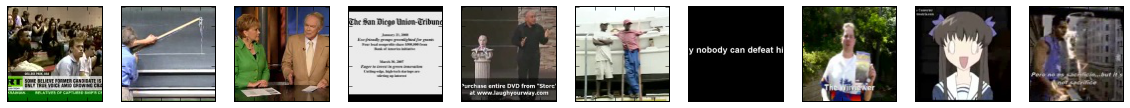

In [5]:
draw_img_rgb(x_train[:10])

# モデル定義

In [6]:
class Encoder(chainer.Chain):
    def __init__(self, n_latent=1000, input_size=96, input_ch=3, output_ch=256):
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.input_size = input_size
        self.out_size = input_size/(2**4)
        super(Encoder, self).__init__(
            ec0 = L.Convolution2D(self.input_ch, self.output_ch/8, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.input_ch)),
            ec1 = L.Convolution2D(self.output_ch/8, self.output_ch/4, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/8)),
            ec2 = L.Convolution2D(self.output_ch/4, self.output_ch/2, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/4)),
            ec3 = L.Convolution2D(self.output_ch/2, self.output_ch, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/2)),
            l4_mu = L.Linear(self.out_size*self.out_size*self.output_ch, n_latent, wscale=0.02*math.sqrt(self.out_size*self.out_size*self.output_ch)),
            l4_var = L.Linear(self.out_size*self.out_size*self.output_ch, n_latent, wscale=0.02*math.sqrt(self.out_size*self.out_size*self.output_ch)),
            bne0 = L.BatchNormalization(self.output_ch/8),
            bne1 = L.BatchNormalization(self.output_ch/4),
            bne2 = L.BatchNormalization(self.output_ch/2),
            bne3 = L.BatchNormalization(self.output_ch),
            )

    def __call__(self, x, test=False):
        h = F.relu(self.bne0(self.ec0(x), test=test))
        h = F.relu(self.bne1(self.ec1(h), test=test))
        h = F.relu(self.bne2(self.ec2(h), test=test))
        h = F.relu(self.bne3(self.ec3(h), test=test))
        mu = (self.l4_mu(h))
        var = (self.l4_var(h))
        return mu, var

In [7]:
class Decoder(chainer.Chain):
    def __init__(self, n_latent=1000, input_size=96, input_ch=3, output_ch=256):
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.input_size = input_size
        self.out_size = input_size/(2**4)
        super(Decoder, self).__init__(
            # decoder
            l0z = L.Linear(n_latent, self.out_size*self.out_size*self.output_ch, wscale=0.02*math.sqrt(n_latent)),
            dc1 = L.Deconvolution2D(self.output_ch, self.output_ch/2, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch)),
            dc2 = L.Deconvolution2D(self.output_ch/2, self.output_ch/4, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/2)),
            dc3 = L.Deconvolution2D(self.output_ch/4, self.output_ch/8, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/4)),
            dc4 = L.Deconvolution2D(self.output_ch/8, self.input_ch, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/8)),
            bnd0l = L.BatchNormalization(self.out_size*self.out_size*self.output_ch),
            bnd0 = L.BatchNormalization(self.output_ch),
            bnd1 = L.BatchNormalization(self.output_ch/2),
            bnd2 = L.BatchNormalization(self.output_ch/4),
            bnd3 = L.BatchNormalization(self.output_ch/8),
            )

    def __call__(self, z, sigmoid=True, test=False):
        h = F.reshape(F.relu(self.bnd0l(self.l0z(z), test=test)), (z.data.shape[0], self.output_ch, self.out_size, self.out_size))
        h = F.relu(self.bnd1(self.dc1(h), test=test))
        h = F.relu(self.bnd2(self.dc2(h), test=test))
        h = F.relu(self.bnd3(self.dc3(h), test=test))
        x = (self.dc4(h))
        if sigmoid:
            return F.sigmoid(x)
        else:
            return x

In [8]:
class Discriminator(chainer.Chain):
    def __init__(self, n_latent=1000, input_size=96, input_ch=3, output_ch=256):
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.input_size = input_size
        self.out_size = input_size/(2**4)
        super(Discriminator, self).__init__(
            # discriminator
            gc0 = L.Convolution2D(self.input_ch, self.output_ch/8, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.input_ch)),
            gc1 = L.Convolution2D(self.output_ch/8, self.output_ch/4, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/8)),
            gc2 = L.Convolution2D(self.output_ch/4, self.output_ch/2, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/4)),
            gc3 = L.Convolution2D(self.output_ch/2, self.output_ch, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/2)),
            gl = L.Linear(self.out_size*self.out_size*self.output_ch, 2, wscale=0.02*math.sqrt(self.out_size*self.out_size*self.output_ch)),
            gn0 = L.BatchNormalization(self.output_ch/8),
            gn1 = L.BatchNormalization(self.output_ch/4),
            gn2 = L.BatchNormalization(self.output_ch/2),
            gn3 = L.BatchNormalization(self.output_ch),
            )

    def __call__(self, rec, test=False):
        h0 = F.relu(self.gn0(self.gc0(rec), test=test))
        h1 = F.relu(self.gn1(self.gc1(h0), test=test))
        h2 = F.relu(self.gn2(self.gc2(h1), test=test))
        h3 = F.relu(self.gn3(self.gc3(h2), test=test))
        d = self.gl(h3)
        hidden_out = [h0, h1, h2, h3]
        return d, hidden_out


# 学習
## 学習パラメータの設定

In [15]:
gpu_flag = 3

batchsize = 100 # ミニバッチのサイズ
n_epoch = 50     # epoch数
n_latent = 1000   # 潜在変数の次元(DCGANで言うところのプライヤーベクトルの次元)
conv_size = 256  # convolution層の最大チャネルサイズ

kl_weight = 1.0
gamma = 1.0 # VAEとGANの重みを変えるためのパラメータ

# Optimizer(Adam)
al = 0.0001
b1 = 0.5
b2 = 0.999

# image size
size = 96

## Optimizerの設定

In [19]:
encode = Encoder(input_size=size, n_latent=n_latent, output_ch=conv_size)
decode = Decoder(input_size=size, n_latent=n_latent, output_ch=conv_size)
disc = Discriminator(input_size=size, n_latent=n_latent, output_ch=conv_size)

# GPU設定
if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    encode.to_gpu()
    decode.to_gpu()
    disc.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

# Optimizerの設定
o_enc = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
o_dec = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
o_dis = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
o_enc.setup(encode)
o_dec.setup(decode)
o_dis.setup(disc)


## 訓練の実行

In [20]:
loss_buf = pd.DataFrame(columns=['epoch', 'enc_loss', 'dec_loss', 'dis_loss', 'gan_loss', 'like_loss', 'prior_loss'])

In [21]:
for epoch in six.moves.range(1, n_epoch + 1):
    # training
    ## 訓練データのsampler
    perm = np.random.permutation(N_train)
    ## lossのbuffer
    sum_enc_loss = 0.
    sum_dec_loss = 0.
    sum_dis_loss = 0.
    sum_gan = 0.
    sum_like = 0.
    sum_prior = 0.
    ## バッチ学習
    for i in six.moves.range(0, N_train, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]])) # バッチ分のデータの抽出
        
        ##### Lossの計算
        # KL距離
        mu, ln_var = encode(x, test=False)
        x_rec = decode(mu, sigmoid=True)
        batchsize = len(mu.data)
        kl_loss = gaussian_kl_divergence(mu, ln_var) / reduce(lambda x,y:x*y, mu.data.shape)
        #print 'mu={}'.format(mu.data.shape)
        #print 'var={}'.format(ln_var.data.shape)
        #print 'kl_loss={}'.format(kl_loss.data)
        
        # ランダムzの生成とランダムzでのdecode
        ## zはN(0, 1)から生成
        z_p = xp.random.standard_normal(mu.data.shape).astype('float32')
        z_p = chainer.Variable(z_p)
        x_p = decode(z_p) 
        
        # Discriminatorの出力を得る
        d_x_rec, h_out_rec = disc(x_rec)
        d_x_base, h_out_base = disc(x)
        d_x_p, h_out_p = disc(x_p)
        # Discriminatorのsoftmax_cross_entropy
        L_rec = F.softmax_cross_entropy(d_x_rec, Variable(xp.zeros(batchsize, dtype=np.int32)))
        L_base = F.softmax_cross_entropy(d_x_base, Variable(xp.ones(batchsize, dtype=np.int32)))
        L_p = F.softmax_cross_entropy(d_x_p, Variable(xp.zeros(batchsize, dtype=np.int32)))
        
        # Reconstruction Errorを得る(Discriminatorの中間出力の誤差)
        rec_loss = (F.mean_squared_error(h_out_rec[0], h_out_base[0]) 
                    + F.mean_squared_error(h_out_rec[1], h_out_base[1]) 
                    + F.mean_squared_error(h_out_rec[2], h_out_base[2]) 
                    + F.mean_squared_error(h_out_rec[3], h_out_base[3]) ) / 4.0
        ##### Loss計算ここまで
        
        l_gan = (L_base + L_rec + L_p) / 3.0
        l_like = rec_loss
        l_prior = kl_loss
        
        enc_loss = kl_weight * l_prior + l_like
        dec_loss = gamma*l_like - l_gan
        dis_loss = l_gan
        
        ##### パラメータの更新
        # Encoder
        o_enc.zero_grads()
        enc_loss.backward()
        o_enc.update()
        # Decoder
        o_dec.zero_grads()
        dec_loss.backward()
        o_dec.update()
        #Discriminator
        o_dis.zero_grads()
        dis_loss.backward()
        o_dis.update()
        ##### パラメータの更新ここまで
        
        sum_enc_loss += enc_loss.data
        sum_dec_loss += dec_loss.data
        sum_dis_loss += dis_loss.data
        
        sum_gan += l_gan.data
        sum_like += l_like.data
        sum_prior += l_prior.data

    print 'epoch:{}, enc={}, dec={}, dis={}, gan={}, like={}, prior={}'.format(epoch, sum_enc_loss, sum_dec_loss, sum_dis_loss, 
                                                   sum_gan, sum_like, sum_prior)
    df_tmp = pd.DataFrame([[epoch, sum_enc_loss, sum_dec_loss, sum_dis_loss, sum_gan, sum_like, sum_prior]], 
                          columns=['epoch','enc_loss', 'dec_loss', 'dis_loss', 'gan_loss', 'like_loss', 'prior_loss'])
    loss_buf = loss_buf.append(df_tmp, ignore_index=True)

epoch:1, enc=16.6482696533, dec=3.86322855949, dis=2.36053276062, gan=2.36053276062, like=6.22376060486, prior=10.4245080948
epoch:2, enc=12.2284650803, dec=5.52157306671, dis=0.793737053871, gan=0.793737053871, like=6.31531000137, prior=5.91315460205
epoch:3, enc=10.5017967224, dec=5.64741945267, dis=0.683199584484, gan=0.683199584484, like=6.33061885834, prior=4.17117786407
epoch:4, enc=9.24171924591, dec=5.7296037674, dis=0.590121805668, gan=0.590121805668, like=6.3197259903, prior=2.92199349403
epoch:5, enc=8.40072059631, dec=5.87977075577, dis=0.428577542305, gan=0.428577542305, like=6.30834770203, prior=2.09237337112
epoch:6, enc=7.8804473877, dec=6.02749300003, dis=0.279164582491, gan=0.279164582491, like=6.30665779114, prior=1.57378995419
epoch:7, enc=7.52498435974, dec=6.1308298111, dis=0.152973517776, gan=0.152973517776, like=6.28380298615, prior=1.24118041992
epoch:8, enc=7.27691030502, dec=6.1964468956, dis=0.0300800781697, gan=0.0300800781697, like=6.22652721405, prior=1.0

In [25]:
loss_buf[:5]

,epoch,enc_loss,dec_loss,dis_loss,gan_loss,like_loss,prior_loss
0,1.0,16.6482696533,3.86322855949,2.36053276062,2.36053276062,6.22376060486,10.4245080948
1,2.0,12.2284650803,5.52157306671,0.793737053871,0.793737053871,6.31531000137,5.91315460205
2,3.0,10.5017967224,5.64741945267,0.683199584484,0.683199584484,6.33061885834,4.17117786407
3,4.0,9.24171924591,5.7296037674,0.590121805668,0.590121805668,6.3197259903,2.92199349403
4,5.0,8.40072059631,5.87977075577,0.428577542305,0.428577542305,6.30834770203,2.09237337112


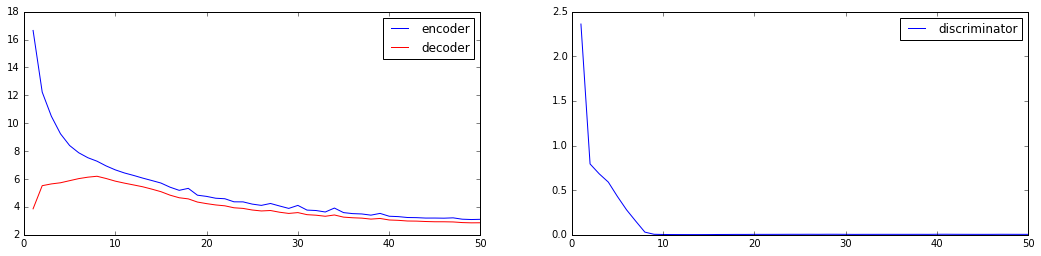

In [28]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_buf['epoch'], loss_buf['enc_loss'], color="#0000FF", label="encoder")
plt.plot(loss_buf['epoch'], loss_buf['dec_loss'], color="#FF0000", label="decoder")
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.plot(loss_buf['epoch'], loss_buf['dis_loss'], color="#0000FF", label="discriminator")
plt.legend(loc='upper right')

Reconstruct Test [Closed Test]
[900 801 606 101 839 985 892 129 366 119]


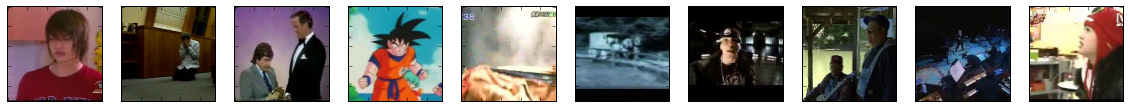

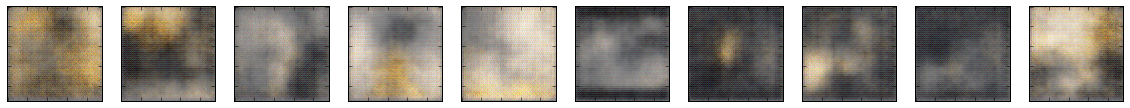

In [22]:
test_ind = np.random.permutation(N_train)[:10]
print "Reconstruct Test [Closed Test]"
print test_ind
x = chainer.Variable(xp.asarray(x_train[test_ind]), volatile='on')
mu, ln_var = encode(x, test=True)
x_rec = decode(mu, sigmoid=True)

draw_img_rgb(x_train[test_ind])
draw_img_rgb(x_rec.data.get())